In [1]:
import pandas as pd
import re

In [70]:
df = pd.read_csv('../data/loans_2007.csv')
OrgRowCount = df.shape[0]
OrgColCount = df.shape[1]


# NA reduction simple clean

In [3]:
# drop dublicated last rows seem to be sum of above
df = df.drop_duplicates()

In [4]:
## there seems to 3 very none pullted
df = df.dropna(thresh=50,axis=0)

In [5]:
# revol_util kill some missing and transform to float
df = df[~df.revol_util.isna()]
df.revol_util = df.revol_util.apply(lambda x: str(x).replace('%','')).astype('float64')/100

In [6]:
# emp_length transfrom form string to number (<1 years ,  years, 10+ years etc)
def Trans_empValue(s):
    if type(s) is float:
        return 0.
   
    if re.search('\<',s):
        return 0.5
    else:
        return float(re.search('\d+',s).group())

    
df.emp_length = df.emp_length.apply(lambda x: Trans_empValue(x))

In [7]:
# intrest rate seems to be string with %
df.int_rate = df.int_rate.apply(lambda x: str(x).replace('%','')).astype('float64')/100
# more to fix

In [8]:
# pub_rec_bankruptcies - assume no value is none 
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.fillna(0.0).astype('int32')
df.pub_rec_bankruptcies = df.pub_rec_bankruptcies.apply(lambda x: 1 if x > 0 else 0)
df.pub_rec_bankruptcies.value_counts()

0    40477
1     1853
Name: pub_rec_bankruptcies, dtype: int64

In [9]:
# title could be filtered by keyword debt etc.. but catgoriy of purpose do better job
# thereby drop it
df = df.drop(['title'], axis=1)

In [10]:
## last_credit_pull_d kill the view that have no entrys 
df = df[~df.last_credit_pull_d.isna()]

## 

In [11]:
# last_pymnt_d thouse without value have meaning - start feature engineering here to ever payed
display(df[df.last_pymnt_d.isna()].loan_status.value_counts())
df['has_made_pymnt'] = df.last_pymnt_d.apply(lambda x: 1 if x else 0)
df = df.drop(['last_pymnt_d'],axis=1)


Charged Off                                            62
Does not meet the credit policy. Status:Charged Off    12
Name: loan_status, dtype: int64

In [12]:
# emp_title -- simple way is at least extract if self employed keyword ,self,retired,NAN, all others - army etc...
#df.emp_title 
#df[df.emp_length == 0].emp_title.value_counts() #nunique()
# !! for now drop !! 
df = df.drop(['emp_title'],axis=1)

In [13]:
df.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prnc

In [14]:
df.shape

(42329, 50)

# Droping more features

In [15]:
# collections_12_mths_ex_med and chargeoff_within_12_mths drop the column all are the same = 0.0
df = df.drop(['chargeoff_within_12_mths', 'collections_12_mths_ex_med'], axis=1)


In [16]:
# application_type - only indvitual in the data can be droped
df = df.drop(['application_type'],axis=1)

In [17]:
# no info 
df = df.drop(['initial_list_status'],axis=1)


In [18]:
# no info in the data 
df = df.drop(['acc_now_delinq'],axis=1)

In [19]:
# not much info only 2 
df = df.drop(['delinq_amnt'],axis=1)

In [20]:
# only one value diffrent
df = df.drop(['tax_liens'],axis=1)

In [21]:
# all have no only one is yes
df = df.drop(['pymnt_plan'],axis=1)

In [22]:
# all are 1
df = df.drop(['policy_code'],axis=1)

In [23]:
# drop because not clear waht it means ...
df = df.drop(['verification_status'],axis=1)

In [ ]:
# TODO check grad and sub grade seem to over info!

In [24]:
df.shape

(42329, 40)

# Dublication check and kill

In [25]:
df.id.duplicated().value_counts()

False    42329
Name: id, dtype: int64

In [26]:
df.member_id.duplicated().value_counts()

False    42329
Name: member_id, dtype: int64

In [27]:
## since no doubles drop them as there are keys 
df = df.drop(['id','member_id'],axis=1)

# Types - filter real categoricals...

In [35]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42329 entries, 0 to 42474
Data columns (total 10 columns):
term                  42329 non-null object
grade                 42329 non-null object
sub_grade             42329 non-null object
home_ownership        42329 non-null object
loan_status           42329 non-null object
purpose               42329 non-null object
zip_code              42329 non-null object
addr_state            42329 non-null object
earliest_cr_line      42329 non-null object
last_credit_pull_d    42329 non-null object
dtypes: object(10)
memory usage: 3.6+ MB


In [29]:
## can be used as is wehn transformed to dummy
df.term.unique() #-> LabelEncoder or dummy

array([' 36 months', ' 60 months'], dtype=object)

In [30]:
# only for distance of payment possible to use but not of value for a new customer - > drop
df = df.drop(['issue_d'],axis=1)

In [31]:
print(df.home_ownership.value_counts())
# combine NONE and OTHER
df.home_ownership = df.home_ownership.apply(lambda x: 'OTHER' if x=='NONE' else x)


RENT        20073
MORTGAGE    18890
OWN          3230
OTHER         134
NONE            2
Name: home_ownership, dtype: int64


In [34]:
print(df.home_ownership.value_counts()) ## use with dummy 

RENT        20073
MORTGAGE    18890
OWN          3230
OTHER         136
Name: home_ownership, dtype: int64


In [38]:
## keep but just use state as predictor initialy
#df.addr_state
#df.zip_code

In [39]:
#earliest_cr_line --- could be transformned to pseudo age or crdit expirence
Today = 'Dec-2011'

#df.earliest_cr_line.head()

0    Jan-1985
1    Apr-1999
2    Nov-2001
3    Feb-1996
4    Jan-1996
Name: earliest_cr_line, dtype: object

In [42]:
df.last_credit_pull_d.value_counts() # ????!?!? # is not so usfull for inital customer eval

Jun-2016    12463
Mar-2016     1112
Apr-2016      908
Feb-2013      880
May-2016      766
Feb-2016      739
Jan-2016      661
Dec-2015      654
Mar-2013      610
Dec-2014      567
Mar-2014      566
Jul-2014      563
Sep-2014      562
Jul-2015      546
Feb-2014      541
Sep-2015      531
Aug-2014      528
Oct-2014      528
Jan-2014      528
Nov-2015      516
Oct-2015      512
Apr-2014      504
Nov-2014      499
Nov-2013      490
May-2014      476
May-2013      470
Jun-2014      468
Jan-2015      447
Apr-2013      445
Aug-2015      435
            ...  
Aug-2010       60
Jun-2010       52
Oct-2009       50
Nov-2009       48
Jan-2013       38
Jan-2009       36
Jan-2010       34
Aug-2009       30
Apr-2009       24
Jul-2009       21
Feb-2009       20
Sep-2009       19
Jun-2009       18
Mar-2009       17
Aug-2008       15
May-2009       14
Oct-2008       13
Aug-2007       13
Sep-2008        9
Mar-2008        8
Dec-2008        7
Sep-2007        5
Jan-2008        4
Nov-2007        3
Feb-2008  

In [45]:
df.select_dtypes('float').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42329 entries, 0 to 42474
Data columns (total 25 columns):
loan_amnt                  42329 non-null float64
funded_amnt                42329 non-null float64
funded_amnt_inv            42329 non-null float64
int_rate                   42329 non-null float64
installment                42329 non-null float64
emp_length                 42329 non-null float64
annual_inc                 42329 non-null float64
dti                        42329 non-null float64
delinq_2yrs                42329 non-null float64
inq_last_6mths             42329 non-null float64
open_acc                   42329 non-null float64
pub_rec                    42329 non-null float64
revol_bal                  42329 non-null float64
revol_util                 42329 non-null float64
total_acc                  42329 non-null float64
out_prncp                  42329 non-null float64
out_prncp_inv              42329 non-null float64
total_pymnt                42329 non-null

In [44]:
df.select_dtypes('int').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42329 entries, 0 to 42474
Data columns (total 2 columns):
pub_rec_bankruptcies    42329 non-null int64
has_made_pymnt          42329 non-null int64
dtypes: int64(2)
memory usage: 992.1 KB


# Target def and pseudo Target stashing 

## T1
The purpose of the analysis is to reduce defaults , 

improve profitability and help the 
company and investors determine interest rates. --- > Regression on intrest rate or EDA to intrest rate

## T2
reduce defaults - We will use machine learning models to analyze credit risk as a binary classification problem.


In [32]:
# grade and sub grade
# maybe combine to one feature
## strongly conected to int_rate


In [33]:
#policy_code seems has not value

In [46]:
df.loan_status.value_counts()

Fully Paid                                             33052
Charged Off                                             5606
Does not meet the credit policy. Status:Fully Paid      1917
Current                                                  961
Does not meet the credit policy. Status:Charged Off      738
Late (31-120 days)                                        24
In Grace Period                                           20
Late (16-30 days)                                          8
Default                                                    3
Name: loan_status, dtype: int64

In [ ]:
# Fully Paid - postive
# Does not meet the credit policy. Status:Fully Paid - postive based on compare on annul income

#Current - (half postive not evaluated therfor drop)

# Charged off - negative
# Does not meet the credit policy. Status:Charged Off - negative

# Late (31-120 days) - negative 

# Late (16-30 days) - (half postive not evaluated therfor drop)
# In Grace Period - (half postive not evaluated therfor drop)

# Default - negative



In [66]:
def DefTargetFrom_loan_Status(s):
    if s=='Fully Paid':
        return 1
    elif s=='Does not meet the credit policy. Status:Fully Paid':
        return 1
    elif s=='Charged Off':
        return 0
    elif s=='Does not meet the credit policy. Status:Charged Off':
        return 0
    elif s=='Late (31-120 days)':
        return 0
    elif s=='Default':
        return 0
    else:
        return None

df['target'] = df.loan_status.apply(lambda x: DefTargetFrom_loan_Status(x))
df.isna().sum()
df = df.dropna()
df.shape

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(41340, 39)

In [67]:
df.to_pickle('../data/clean_pass_01.pkl')

In [68]:
df.loan_status

0                                               Fully Paid
1                                              Charged Off
2                                               Fully Paid
3                                               Fully Paid
5                                               Fully Paid
6                                               Fully Paid
7                                               Fully Paid
8                                              Charged Off
9                                              Charged Off
10                                              Fully Paid
11                                              Fully Paid
12                                             Charged Off
13                                              Fully Paid
14                                             Charged Off
15                                              Fully Paid
16                                              Fully Paid
17                                              Fully Pa

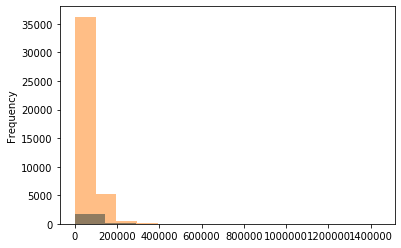

In [55]:
import matplotlib.pyplot as plt

plt.figure()
df[df.loan_status =='Does not meet the credit policy. Status:Fully Paid'].annual_inc.plot.hist()
df[df.annual_inc < 1e6].annual_inc.plot.hist(alpha=0.5)
plt.show()


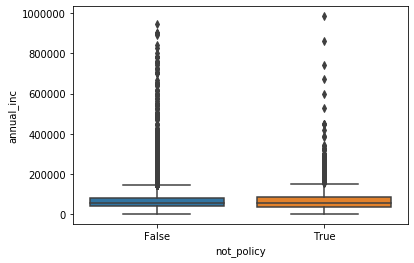

In [59]:
import seaborn as sns
df['not_policy'] = df.loan_status =='Does not meet the credit policy. Status:Fully Paid'
sns.boxplot(y='annual_inc',x='not_policy', data=df[df.annual_inc < 1e6])

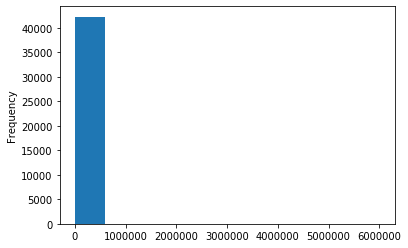

In [50]:
df.annual_inc.plot.hist()

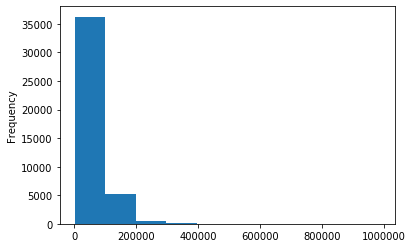

In [52]:
## outlyer correction anual income

